In [6]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import spatial, interpolate

In [7]:
# Self-defined DeepONet
# Consisting of two subnetworks: trunk and branch. Both are FNNs in this case.
# The trunk takes input data x, and the branch takes input data u.
# Return output and gradient of the output w.r.t. x if return_grad is True.
class ONet(tf.keras.Model):
  
  def __init__(self, trunk, branch):
    super(ONet, self).__init__()
    
    self.trunk = trunk
    self.branch = branch

  def call(self, u, x, return_grad = False):

    #y_trunk = self.trunk(x)

    #x_sensor = np.expand_dims(x_sensor, 0)
    u_branch = self.branch(u)
    
    if return_grad:
        with tf.GradientTape(persistent=True) as g1:
            g1.watch(x)
            u_trunk = self.trunk(x)
            #y_out = tf.tensordot(y_branch, y_trunk, axes=([1], [1]))
            u = tf.unstack(u_trunk, axis=1)
        du_x = []
        for us in u:
            du = tf.unstack(g1.gradient(us, x), axis=1)
            du_x.append(du[0])
        du_x = tf.stack(du_x)
        u_out = tf.tensordot(u_branch, u_trunk, axes=([1], [1]))
        du_x  = tf.tensordot(u_branch, du_x, axes=([1], [0]))
        return u_out*tf.transpose((x-1.)*(x+1.)), du_x*tf.transpose((x-1.)*(x+1.)) + u_out*tf.transpose(2*x)

    else:
        u_trunk = self.trunk(x)
        u_out = tf.tensordot(u_branch, u_trunk, axes=([1], [1]))
        
        return u_out*tf.transpose((x-1.)*(x+1.))

  def get_config(self):
        return {"trunk": self.trunk, "branch": self.branch}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [8]:
class FNN(tf.keras.Model):
  
  def __init__(self, n_output, n_layer, n_nodes, activation):
    super(FNN, self).__init__()
    
    layers = []
    for _ in range(n_layer):
        layers.append(tf.keras.layers.Dense(n_nodes, activation=activation))
    self.hidden = layers

    self.out = tf.keras.layers.Dense(n_output, activation='linear')
    self.n_layer = n_layer
    self.n_nodes = n_nodes
    self.activation = activation
    
  def call(self, x):
    
    y = self.hidden[0](x)
    for layer in self.hidden[1:]:
        y= layer(y)
    y = self.out(y)

    return y
  def get_config(self):
        return {"n_layer": self.n_layer, "n_nodes": self.n_nodes, "activation": self.activation}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [9]:
# Step 1. Create model
# Network structure 
n_layer_trunk = 3   # number of hidden layers in the trunk network
n_nodes_trunk = 100   # number of nodes per hidden layer in the trunk network
n_layer_branch = 2   # number of hidden layers in the branch network
n_nodes_branch = 100  # number of nodes per hidden layer in the branch network
n_out_feature = 100   # number of output nodes in the branch network
Net_trunk = FNN(n_out_feature, n_layer_trunk, n_nodes_trunk, 'tanh')
Net_branch = FNN(n_out_feature, n_layer_branch, n_nodes_branch, 'tanh')
u_onet = ONet(Net_trunk, Net_branch)

In [10]:
# Homogeneous free energy density
Fe = lambda u: (u**2 - 1)**2/4 

def physics_informed_loss_sampled(onet, uks, uk, x):
    
    u, du_x = onet(uks, x, return_grad=True)
    uk = tf.reshape(tf.squeeze(uk), [uk.shape[0], -1]) # 4D -> 2D

    L_enegy    = tf.reduce_mean(0.5*du_x**2  + Fe(u)/eps**2)
    L_distance = tf.reduce_mean((uk - u)**2)/tao/2
       
    return L_enegy, L_distance

In [11]:
# Random Gaussian Process
def gaussian_process(x , num_curves, length_scale_list, u_mean=0.):
    '''
    x -  discretized locations of each curve (numpy array of size N X 1)
    num_curves - Number of curves to sample (number of samples)
    length_scale_list - List of length scales (standard deviation) to sample from
    u_mean - Mean of the Gaussian process
    '''
    X = np.expand_dims(x, 1)
    ys = []
    # Draw samples from the prior at our data points.
    # Assume a mean of 0 for simplicity
    for _ in range(num_curves):
        length_scale = np.random.choice(length_scale_list) # Length scale of kernel randomly drawn from a list
        # Exponentiated quadratic kernel (or squared exponential, Gaussian, RBF)
        cov = np.exp(-0.5 * spatial.distance.cdist(X, X, 'sqeuclidean') / length_scale**2) # Kernel of data points
        yst = np.random.multivariate_normal( mean=u_mean * np.ones(len(X)), cov=cov, size=1)
        
        if len(ys) == 0:
            ys = yst
        else:
            ys = np.vstack((ys, yst))
    return ys


def normalize(ys):
    '''
    ys - N X M matrix of M curves with N points each
    Normalize the data to be between -1 and 1
    '''
    if (np.max(np.abs(ys)) > 1):
        ys = np.divide(ys, np.reshape(np.max(np.abs(ys), 1), (-1,1)) )
    return ys



In [12]:
# Training data for x
def x_train(Nx):
    x = np.linspace(-1, 1, Nx).reshape(-1, 1)
    return tf.constant(x, dtype=tf.float32)


In [13]:
# Training data for u_k
def u_train(x, Nu, length_scale_list, u_mean=0.):
    x = x[:,0].numpy()
    u = gaussian_process(x, Nu, length_scale_list, u_mean)
    u = 0.8*u*(x+1.)*(x-1.)
    #u = normalize(u)
    # matrix of sign of u
    u = np.exp(1.5*(1 - np.abs(u))) * u
    return tf.constant(u, dtype=tf.float32)

In [14]:
# Step 3.0 Generate training data
Nx = 100  # number of training data for x (discreted locations along x-axis)
Nu = 2000 # number of training data for u (inputs for branch network)
length_scale = [ 0.5, 1.0] # length scale for the kernel

X = x_train(Nx)
print(f'size of x = {X.shape}')
uk = u_train(X, Nu, length_scale)
print(f'size of uk = {uk.shape}')
# Create a dataset object for X_PDE
u_train_dataset = tf.data.Dataset.from_tensor_slices(uk)
# Shuffle and batch data
u_train_dataset = u_train_dataset.shuffle(buffer_size=Nu).batch(256)


size of x = (100, 1)
size of uk = (2000, 100)


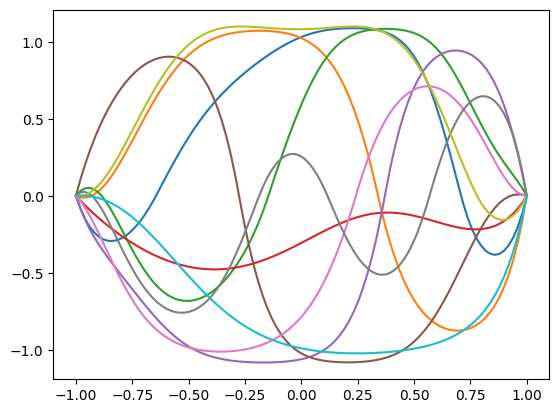

In [15]:
# sample 20 points out of 100 for each curve in uk
uk_sampled = uk[:,::5]
uk_sampled_train_dataset = tf.data.Dataset.from_tensor_slices((uk_sampled, uk))
uk_sampled_train_dataset = uk_sampled_train_dataset.shuffle(buffer_size=Nu).batch(256)
# print(f'uk_sampled_train_dataset = {uk_sampled_train_dataset.shape[0]}')

for i in range(10):
    plt.plot(X[:,0],uk[i,:])

In [17]:
# Parameter in Allen-Cahn equation
eps = 0.1

# 3.1. Define optimizer
#optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# 3.2. Define training loop
epochs = 10
tao = 0.002
# loop over epochs, each epoch contains all batches, each batch contains batch_size data
# read data from X_PDE_dataset
for epoch in range(epochs):
    for uks, uk in uk_sampled_train_dataset:
        with tf.GradientTape() as g:
            # calculate loss
            L_energy, L_distance = physics_informed_loss_sampled(u_onet, uks, uk, X)
            loss = L_energy + L_distance
        # calculate gradient
        grads = g.gradient(loss, u_onet.trainable_variables)
        # update weights
        optimizer.apply_gradients(zip(grads, u_onet.trainable_variables))
        
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, L_energy: {L_energy:.4f}, L_distance: {L_distance:.4f}')

Epoch [1/10], Loss: 36.6327, L_energy: 12.7894, L_distance: 23.8433
Epoch [2/10], Loss: 35.5797, L_energy: 12.7396, L_distance: 22.8400
Epoch [3/10], Loss: 35.3415, L_energy: 12.3504, L_distance: 22.9910
Epoch [4/10], Loss: 34.6806, L_energy: 12.0222, L_distance: 22.6584
Epoch [5/10], Loss: 33.7051, L_energy: 12.3800, L_distance: 21.3251
Epoch [6/10], Loss: 33.8044, L_energy: 12.1277, L_distance: 21.6767
Epoch [7/10], Loss: 32.5050, L_energy: 12.0943, L_distance: 20.4106
Epoch [8/10], Loss: 34.6646, L_energy: 12.0119, L_distance: 22.6527
Epoch [9/10], Loss: 35.0282, L_energy: 11.9924, L_distance: 23.0358
Epoch [10/10], Loss: 33.2716, L_energy: 11.9388, L_distance: 21.3328


In [18]:
def plot_2D(xlim=None, ylim=None, xticks=None, yticks=None, 
            xlabel = 'x', ylabel = 'y',
            figsize=(7.3, 5.9), label_size=18, tick_size=16, spine_width=1.5):
    
    fig, ax = plt.subplots(figsize=figsize) 

    #-----Format Axis --------------------------- 
    # labels and size
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    
    # limits, ticks and size
    if xlim != None:
        ax.set_xlim(*xlim)
    if ylim != None:
        ax.set_ylim(*ylim)
        
    if xticks != None:
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        
    for tick in ax.get_xticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)
    for tick in ax.get_yticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)

    #---------- Spines -------
    ax.spines["top"].set_linewidth(spine_width)
    ax.spines["left"].set_linewidth(spine_width)
    ax.spines["right"].set_linewidth(spine_width)
    ax.spines["bottom"].set_linewidth(spine_width)
    
    return fig, ax

In [19]:
# Solve Allen-Cahn equation in 1D using finite difference method 
# For Dirichlet boundary condition
def allen_cahn_fd(u0,eps,dt,dx):
    Nx = u0.shape[0]
    ut = np.zeros(Nx)
    # Dirichlet boundary condition
    ut[0] = 0.
    ut[-1] = 0.
    for i in range(1,Nx-1):
        # Numerical scheme
        ut[i] = u0[i] + dt*((u0[i-1] - 2*u0[i] + u0[i+1])/dx**2 + (u0[i] - u0[i]**3)/eps**2)
    return ut

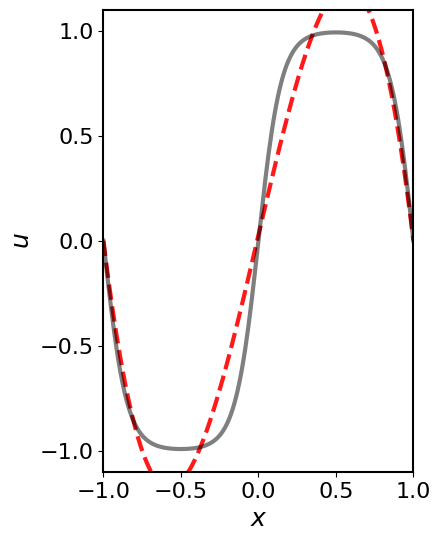

In [20]:
X = tf.linspace(-1., 1., 100)
X = tf.reshape(X, (-1, 1))

xlim = [-1, 1]
ylim = [-1.1, 1.1]
xticks = [-1.0, -0.5, 0, 0.5, 1.0]
yticks = xticks
xlabel = r"$\mathit{x}$"
ylabel = r"$\mathit{u}$"

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel, figsize=(4, 6))

u0 = tf.sin(np.pi*X)
u0 = tf.transpose(u0)
#ln, = ax.plot(X, tf.transpose(u0), 'k', linewidth = 3, alpha=0.1, label = 't=0')
x = np.linspace(-1, 1, 200)
dt = 0.00001
dx = x[1] - x[0]
for ti in [10]:
    u_pred = u0
    for _ in range(ti):
        u_pred = u_onet(u_pred[:,::5], X)
    
    tt = ti*tao
    #u_exact = tf.sin(np.pi*x)
    u_exact = tf.sin(np.pi*x)
    for _ in range(int(tt/dt)):
        u_exact = allen_cahn_fd(u_exact, eps, dt, dx)
    
    #ln1, = ax.plot(X, tf.transpose(u_pred), 'ro', markevery=2, markersize=6, 
    #    markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 0.1 + 0.08*ti])
    ln1, = ax.plot(X, tf.transpose(u_pred), 'r--', linewidth = 3, alpha=0.9,)

    label_t = f't={tt:.2f}'
        
    ln2, = ax.plot(x, u_exact, 'k', linewidth = 3, alpha=0.5, label = label_t)
    
#leg1 = ax.legend([ln1], ['Prediction'], fontsize='x-large',  loc='upper left', bbox_to_anchor=(0.25, 0.95))
#ax.legend(fontsize='x-large') #, bbox_to_anchor=(0.28, 0.95))
#ax.add_artist(leg1)
#plt.savefig('1D_PINN_Sin_10.svg', dpi=300)

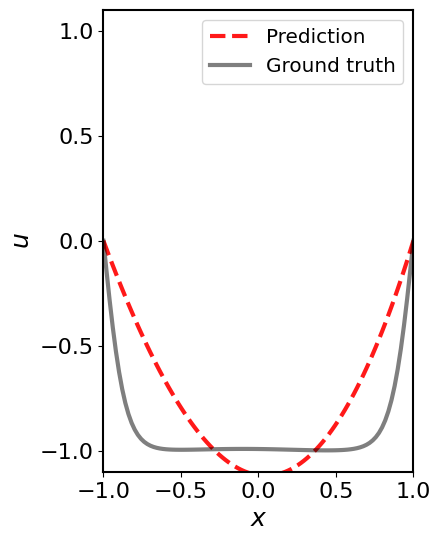

In [21]:
X = tf.linspace(-1., 1., 100)
X = tf.reshape(X, (-1, 1))

xlim = [-1, 1]
ylim = [-1.1, 1.1]
xticks = [-1.0, -0.5, 0, 0.5, 1.0]
yticks = xticks
xlabel = r"$\mathit{x}$"
ylabel = r"$\mathit{u}$"

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel, figsize=(4, 6))

kk = 58
u0 = uk[kk:kk+1,:]
#ln, = ax.plot(X, tf.transpose(u0), 'k', linewidth = 3, alpha=0.1, label = 't=0')
x = np.linspace(-1, 1, 100)
dt = 0.00001
dx = x[1] - x[0]
for ti in [10]:
    u_pred = u0
    for _ in range(ti):
        u_pred = u_onet(u_pred[:,::5], X)
    
    tt = ti*tao
    #u_exact = tf.sin(np.pi*x)
    u_exact = uk[kk,:]
    for _ in range(int(tt/dt)):
        u_exact = allen_cahn_fd(u_exact, eps, dt, dx)
    
    #ln1, = ax.plot(X, tf.transpose(u_pred), 'ro', markevery=2, markersize=6, 
    #    markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 0.1 + 0.08*ti])
    ln1, = ax.plot(X, tf.transpose(u_pred), 'r--', linewidth = 3, alpha=0.9, label='Prediction')

    label_t = f't={tt:.2f}'
        
    ln2, = ax.plot(x, u_exact, 'k', linewidth = 3, alpha=0.5, label = 'Ground truth')
    
#leg1 = ax.legend([ln1], ['Prediction'], fontsize='x-large',  loc='upper left', bbox_to_anchor=(0.25, 0.95))
ax.legend(fontsize='x-large') #, bbox_to_anchor=(0.28, 0.95))
#ax.add_artist(leg1)
#plt.savefig('1D_PINN-10.svg', dpi=300)